In [ ]:
################################################################################
######################   UsedCarPrices_CarGurus  ###############################
######################   Regression - Nonlinear  ###############################
######################   lightGBM Optuna HPO GPU ###############################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM


In [ ]:
# Clone lightGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM

! mkdir build

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM
mkdir: cannot create directory ‘build’: File exists


In [ ]:
# Compile
! cmake -DUSE_GPU=1 #avoid ..
! make -j$(nproc)

-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM
[ -1%] Built target lightgbm_capi_objs
[ 88%] Built target lightgbm_objs
[ 90%] Built target _lightgbm
[ 96%] Built target lightgbm


In [ ]:
! sudo apt-get -y install python-pip

! sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna datetime plotly matplotlib==3.4.2 seaborn eli5 shap scikit-learn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython-all-dev python-all python-all-dev python-asn1crypto
  python-cffi-backend python-crypto python-cryptography python-dbus
  python-enum34 python-gi python-idna python-ipaddress python-keyring
  python-keyrings.alt python-pip-whl python-pkg-resources python-secretstorage
  python-setuptools python-six python-wheel python-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python-cryptography-vectors
  python-dbus-dbg python-dbus-doc python-enum34-doc python-gi-cairo
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0 python-fs
  python-gdata python-keyczar python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  libpython-all-dev python-all python-all-dev python-asn1crypto
  python-cffi-backend python-crypto python-cryptography python-dbus
  python-enum34 python-gi python-

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/python-package

! sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.txt -> build/lib/lightgbm
running install_lib
creating /usr/lib/python3.7/site-packages
creating /usr/lib/python3.7/site-packages/lightgbm
copying build/lib/lightgbm/plotting.py -> /usr/lib/python3.7/site-packages/lightgbm
copying build/l

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
from sklearn.model_selection import cross_val_score, KFold

import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
#from optuna.pruners import SuccessiveHalvingPruner
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import eli5 as eli
from eli5.sklearn import PermutationImportance 
from eli5 import show_weights
import webbrowser
from eli5.sklearn import explain_weights_sklearn
from eli5.formatters import format_as_dataframe, format_as_dataframes
import shap 

my_dpi=96

!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat Apr  9 02:36:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |            

In [ ]:
%cd /content/drive/MyDrive/UsedCarsCarGurus/Data/

/content/drive/MyDrive/UsedCarsCarGurus/Data


In [ ]:
# Set seed 
seed_value = 42
os.environ['UsedCarsCarGurus_lightGBMGPU'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
# Read data
df = pd.read_csv('usedCars_final.csv', low_memory=False)

In [ ]:
# Prepare for partitioning data
X = df.drop(['price'],axis=1)
y = df['price']

In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = seed_value)

In [ ]:
train = pd.concat([y_train, X_train], axis=1)

train = pd.get_dummies(train, drop_first=True)

In [ ]:
# Define label and features
label = train[['price']]

# Remove target
features = train.drop(columns = ['price'])

# Extract feature names
feature_names = list(features.columns)

features = features.columns

features = np.array(features)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_PKL


In [ ]:
################################################################################
######################     lightGBM Optuna HPO  ################################
######################        5000 trials       ################################
################################################################################
# Define a function for optimization of hyperparameters
def objective(trial):
    
    joblib.dump(study, 'lightGBM_Optuna_5000_GPU.pkl')

    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 400,1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.00000001,0.01),
        'num_leaves': trial.suggest_int('num_leaves', 300, 1000),
        
        'bagging_freq': trial.suggest_int('bagging_freq', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.7,0.9),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7,0.9),

        'max_depth': trial.suggest_int('max_depth', 10, 50),

        'lambda_l1': trial.suggest_float('lambda_l1', 0.0001, 0.05, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0001, 0.05,  log=True),
        
        'min_child_samples': trial.suggest_int('min_child_samples', 400, 1000),       

        "verbosity": -1
    }

    kf = KFold(n_splits=5,shuffle=False)
    for trn_idx, val_idx in kf.split(train[features], label): 
      train_features, train_label = train[features].iloc[trn_idx], label.iloc[trn_idx]
      # Validation data for the fold
      val_features, val_label = train[features].iloc[val_idx], train_label.iloc[val_idx] 
                                                                          
      # Start timer for each trial
      start = timer()
      model = lgb.LGBMRegressor(**params_lgb_optuna, early_stopping_rounds=150)
      
      # Train the model
      model.fit(train_features, train_label, 
                eval_set = [(val_features, val_label), 
                            (train_features, train_label)], 
                eval_names = ['valid', 'train'])
        

      # predictions
      y_pred_val = model.predict(val_features)

      rmse = mean_squared_error(val_label, y_pred_val,squared=False)
        
      run_time = timer() - start

      return rmse     
  

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('lightGBM_Optuna_5000.pkl'):
    study = joblib.load('lightGBM_Optuna_5000.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)
# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest RMSE', study.best_value)

Start Time           2022-04-04 16:49:36.825676
[LightGBM] [Warning] lambda_l2 is set=0.00017351958885492602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017351958885492602
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=0.00011644304551089386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011644304551089386
Start Time           2022-04-04 16:49:36.825676
End Time             2022-04-05 06:06:42.506780
13:17:05


Number of finished trials: 5000
Best trial: {'n_estimators': 927, 'learning_rate': 0.007767843029617384, 'num_leaves': 358, 'bagging_freq': 9, 'subsample': 0.8963936092554716, 'colsample_bytree': 0.7976053726037338, 'max_depth': 10, 'lambda_l1': 0.026035844026317617, 'lambda_l2': 0.0015275421945347637, 'min_child_

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/trialOptions/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'rmse'}, inplace=True)
trials_df.rename(columns={'params_bagging_freq':'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_lambda_l1':'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2':'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples':'min_child_samples'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves':'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)
trials_df = trials_df.sort_values('rmse', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_5000_GPU.csv', index=False)

      iteration         rmse             datetime_start  \
3757       3757  9568.150263 2022-04-05 02:29:41.252505   
3492       3492  9568.150320 2022-04-05 01:44:51.662051   
2599       2599  9568.150672 2022-04-04 23:20:42.648505   
4187       4187  9568.151004 2022-04-05 03:43:02.649463   
4976       4976  9568.152099 2022-04-05 06:02:45.366627   
...         ...          ...                        ...   
69           69  9568.395599 2022-04-04 17:01:26.649854   
452         452  9568.404063 2022-04-04 17:53:49.070295   
26           26  9568.406380 2022-04-04 16:55:03.423969   
701         701  9568.416565 2022-04-04 18:31:16.114538   
90           90  9568.441082 2022-04-04 17:04:20.918644   

              datetime_complete               duration  bagging_freq  \
3757 2022-04-05 02:29:50.046728 0 days 00:00:08.794223             9   
3492 2022-04-05 01:45:00.403270 0 days 00:00:08.741219            10   
2599 2022-04-04 23:20:50.681541 0 days 00:00:08.033036             9   
418

In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_5000_GPU.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_5000_GPU.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_5000_GPU.html')
fig.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_PKL/

study = joblib.load('lightGBM_Optuna_5000_GPU.pkl')

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_PKL


In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.

fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate', 
                                                       'subsample'])
py.plot(fig, filename='contour_lightGBM_Optuna_5000_GPU.html')
fig.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_5000_GPU.csv')

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/trialOptions


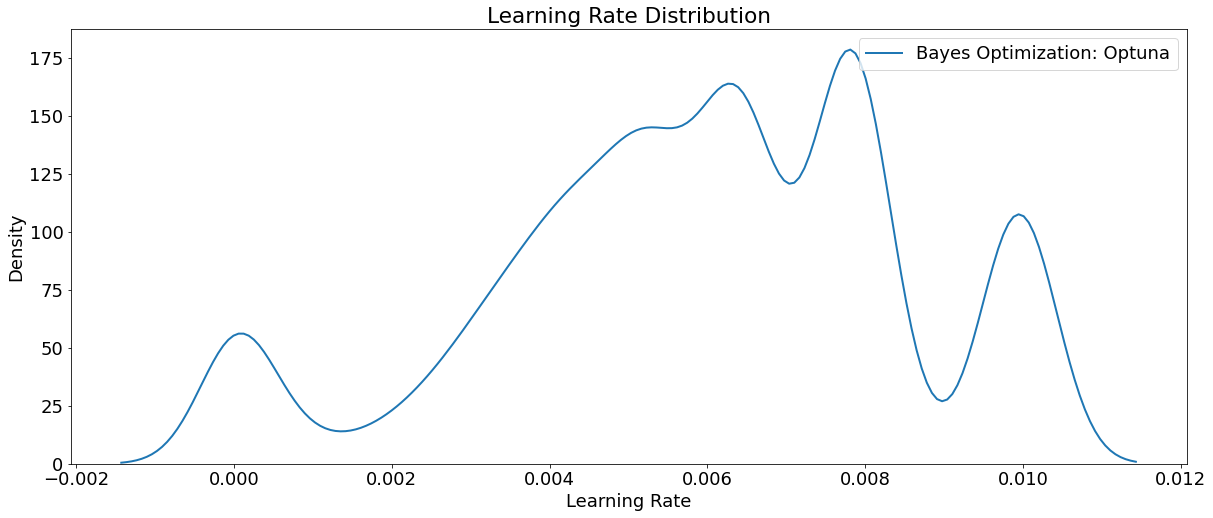

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

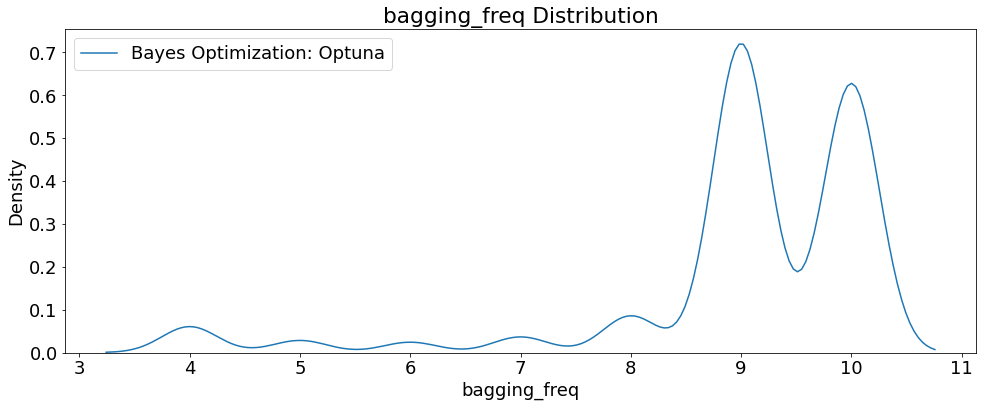

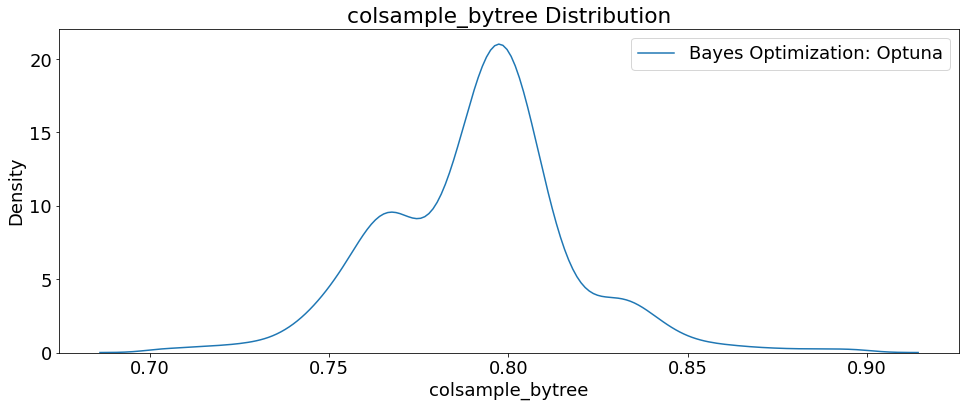

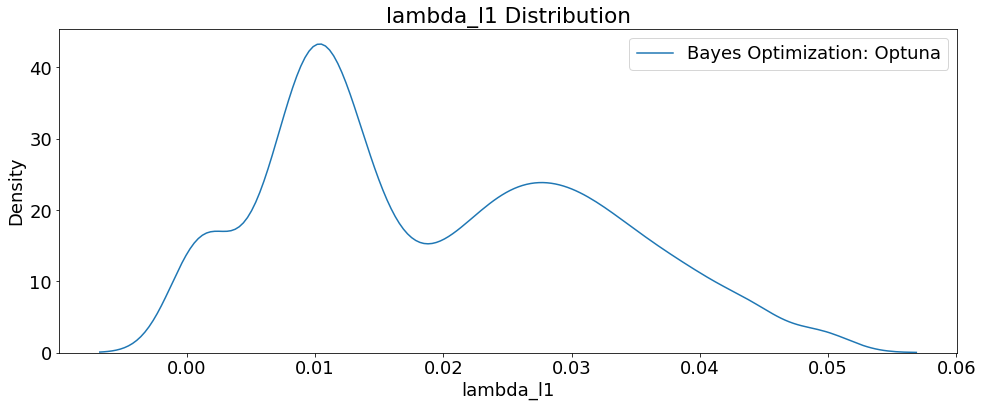

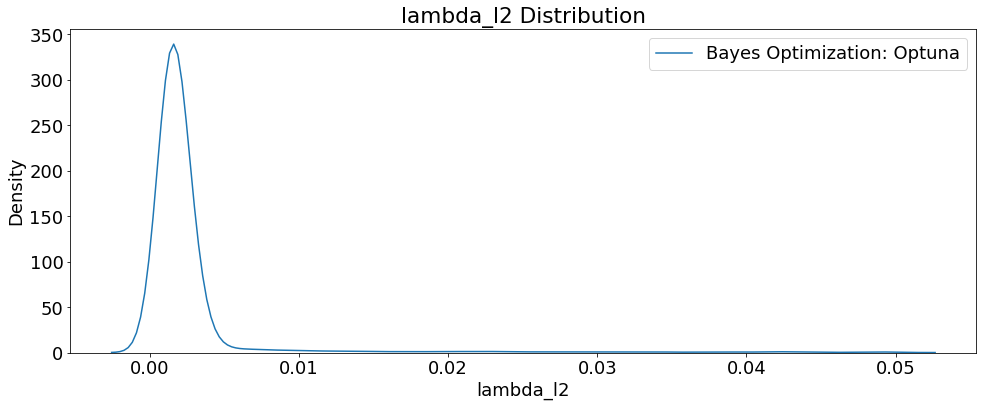

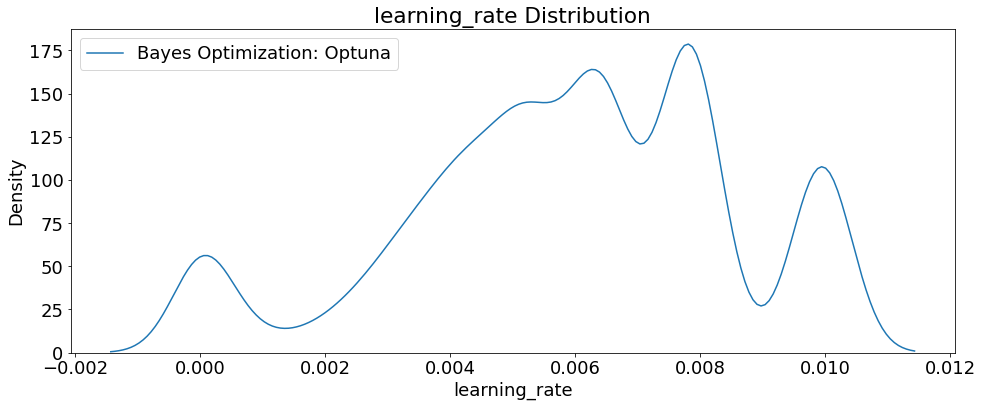

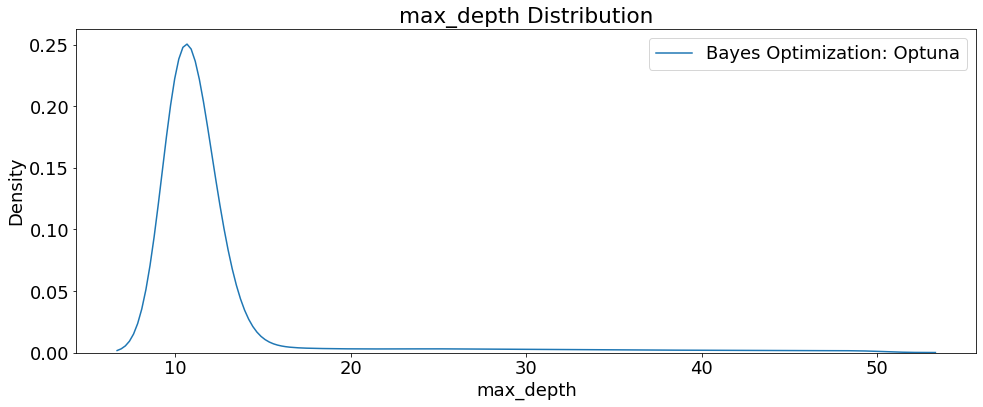

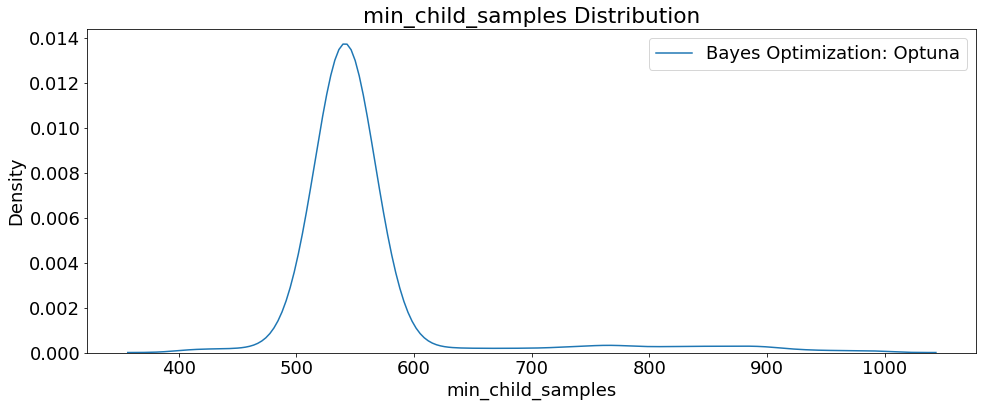

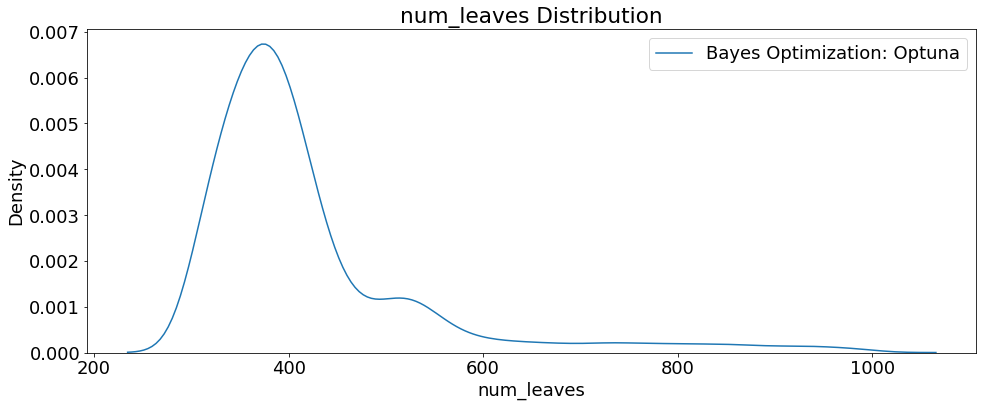

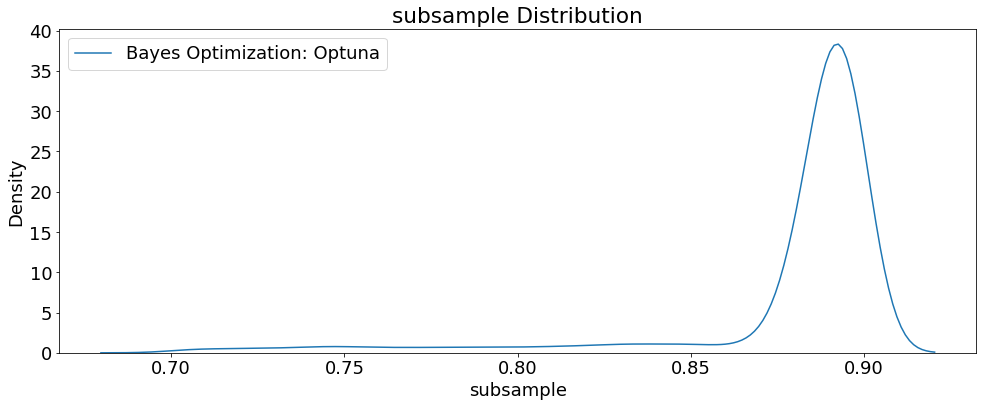

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'rmse', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

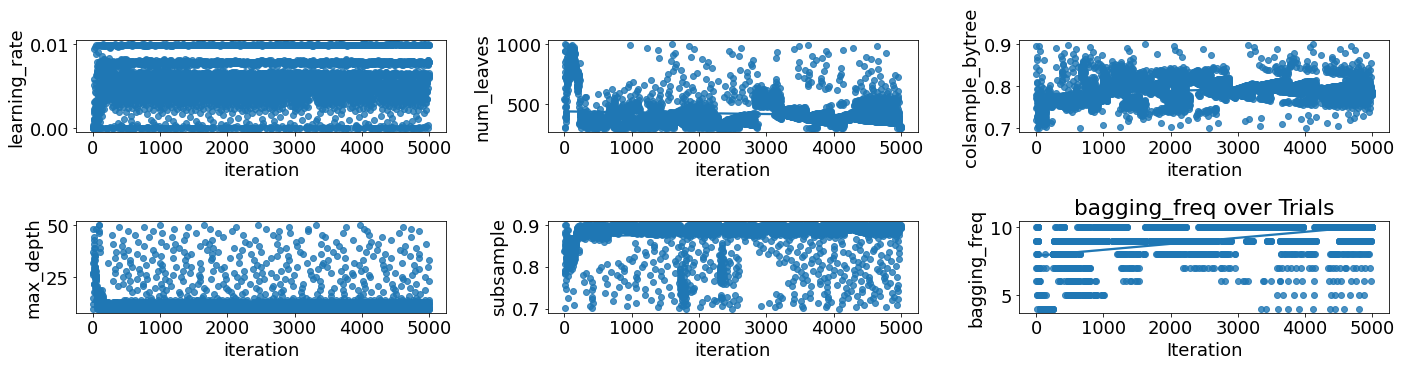

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(2, 3, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


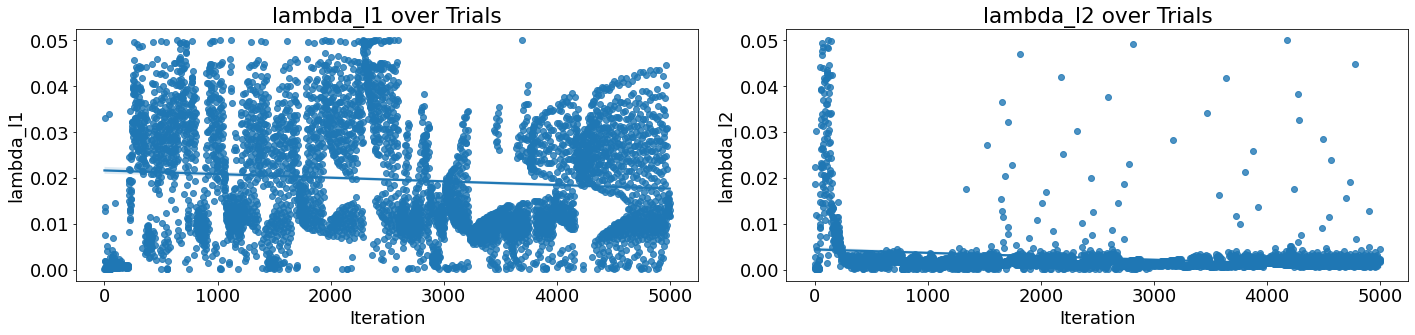

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_5000_GPU.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_5000_GPU.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['metric'] = 'rmse'
params

{'bagging_freq': 9,
 'colsample_bytree': 0.7976053726037338,
 'lambda_l1': 0.026035844026317617,
 'lambda_l2': 0.0015275421945347637,
 'learning_rate': 0.007767843029617384,
 'max_depth': 10,
 'metric': 'rmse',
 'min_child_samples': 543,
 'n_estimators': 927,
 'num_leaves': 358,
 'random_state': 42,
 'subsample': 0.8963936092554716}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_PKL/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_PKL


In [ ]:
# Define label and features
train_label = train[['price']]

# Remove target
train_features = train.drop(columns = ['price'])

In [ ]:
# Re-create the best model and train on the training data
best_model = lgb.LGBMRegressor(**params, verbosity=-1)

# Fit the model
best_model.fit(train_features, train_label)

# Save model
Pkl_Filename = 'lightGBM_Optuna_trials5000_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_Optuna_trials5000_GPU.pkl')
# print(model)
# =============================================================================

[LightGBM] [Warning] lambda_l2 is set=0.0015275421945347637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015275421945347637
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=0.026035844026317617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026035844026317617


In [ ]:
# Create test features
test_features = pd.get_dummies(X_test, drop_first=True)

In [ ]:
print('\nModel Metrics for lightGBM HPO UsedCars_CarGurus 5000 GPU trials')
y_train_pred = best_model.predict(train_features)
y_test_pred = best_model.predict(test_features)

print('MAE train: %.3f, test: %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('RMSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred, squared=False),
        mean_squared_error(y_test, y_test_pred, squared=False)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))



Model Metrics for lightGBM HPO UsedCars_CarGurus 5000 GPU trials
MAE train: 1981.084, test: 2001.404
MSE train: 7041548.716, test: 7178379.330
RMSE train: 2653.592, test: 2679.250
R^2 train: 0.923, test: 0.921


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} MSE on the test set.'.format(mean_squared_error(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 7178379.33009 MSE on the test set.
This was achieved using these conditions:
iteration                                  3757
rmse                                9568.150263
datetime_start       2022-04-05 02:29:41.252505
datetime_complete    2022-04-05 02:29:50.046728
duration                 0 days 00:00:08.794223
bagging_freq                                  9
colsample_bytree                       0.797605
lambda_l1                              0.026036
lambda_l2                              0.001528
learning_rate                          0.007768
max_depth                                    10
min_child_samples                           543
n_estimators                                927
num_leaves                                  358
subsample                              0.896394
state                                  COMPLETE
Name: 0, dtype: object


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_Explanations/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_Explanations


In [ ]:
# Prepare data for SHAP values
train = train.drop(['price'], axis=1)

In [ ]:
# Training Set: Feature Importance Computed with SHAP Values
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(train)

<Figure size 432x288 with 0 Axes>

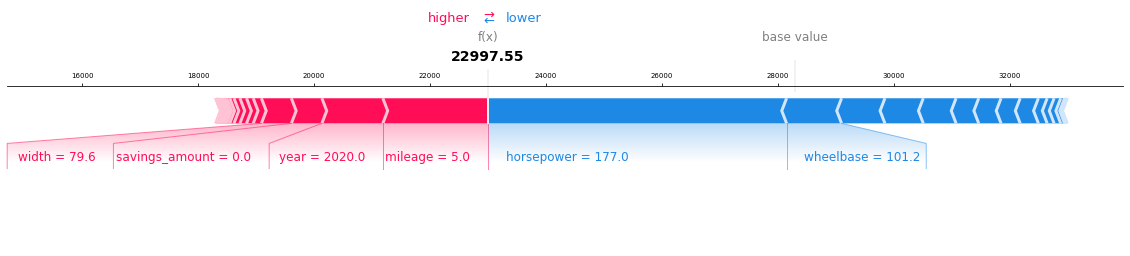

In [ ]:
# Visualize the first prediction's explanation
my_dpi=96
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], train.iloc[0,:], 
                show=False, matplotlib=True).savefig('lightGBM_HPO_Optuna_5000_GPU_ShapForcePlot_TrainSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

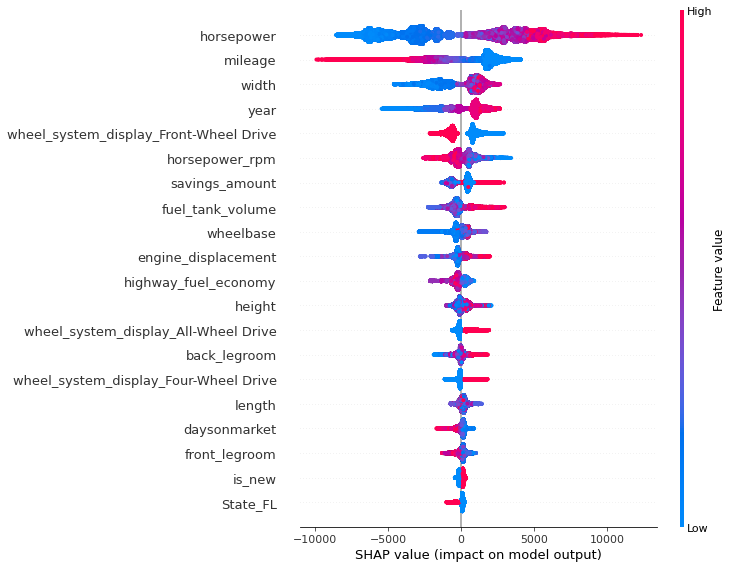

In [ ]:
# Training Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, train, show=False)
fig.savefig('lightGBM_HPO_Optuna_5000_GPU_ShapSummary_TrainSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Test Set: Feature Importance Computed with SHAP Values
shap.initjs()
#explainer = shap.TreeExplainer(best_bayes_model)
shap_values = explainer.shap_values(test_features)

<Figure size 432x288 with 0 Axes>

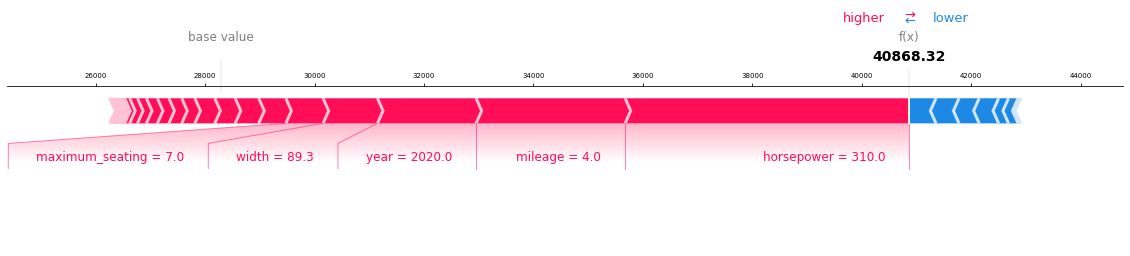

In [ ]:
# Visualize the first prediction's explanation
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.force_plot(explainer.expected_value, shap_values[0,:], test_features.iloc[0,:], 
                show=False, matplotlib=True).savefig('lightGBM_HPO_Optuna_5000_GPU_ShapForcePlot_TestSet.png', 
                                                     dpi=my_dpi, bbox_inches='tight')

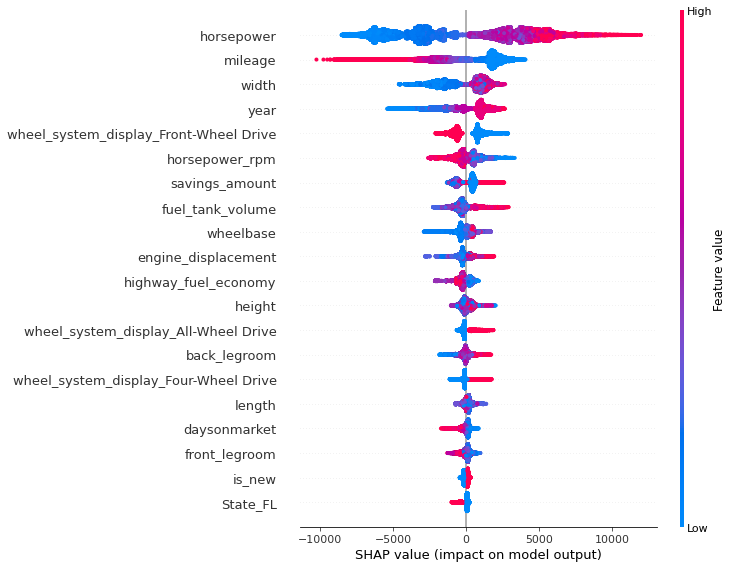

In [ ]:
# Test Set: Summarize the effects of all the features
fig = plt.figure()
plt.rcParams.update({'font.size': 7})
shap.summary_plot(shap_values, test_features, show=False)
fig.savefig('lightGBM_HPO_Optuna_5000_GPU_ShapSummary_TestSet.png', dpi=my_dpi, 
            bbox_inches='tight')

In [ ]:
# Model metrics with Eli5
# Compute permutation feature importance
perm_importance = PermutationImportance(best_model,
                                        random_state=seed_value).fit(test_features,
                                                                     y_test)

[LightGBM] [Warning] lambda_l2 is set=0.0015275421945347637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015275421945347637
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l1 is set=0.026035844026317617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026035844026317617


In [ ]:
# Get the weights
X_test1 = pd.DataFrame(test_features, columns=test_features.columns)                                                                    

# Store feature weights in an object
html_obj = eli.show_weights(perm_importance,
                            feature_names = X_test1.columns.tolist())

# Write feature weights html object to a file 
with open(r'/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_Explanations/best_bayes_Optuna_5000_GPU_WeightsFeatures.htm',
          'wb') as f:
    f.write(html_obj.data.encode("UTF-8"))

# Open the stored feature weights HTML file
url = r'/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/Model_Explanations/best_bayes_Optuna_5000_GPU_WeightsFeatures.htm'
webbrowser.open(url, new=2)

html_obj

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/bestBayes_WeightsExplain/

/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/bestBayes_WeightsExplain


In [ ]:
# Explain weights
explanation = eli.explain_weights_sklearn(perm_importance,
                            feature_names = X_test1.columns.tolist())
exp = format_as_dataframe(explanation)

# Write processed data to csv
exp.to_csv('best_bayes_Optuna_5000_GPU_WeightsExplain.csv',
           index=False, encoding='utf-8-sig')